# Openclassrooms PJ4 : transats dataset : modelisation notebook

In [1]:
%matplotlib inline

import os
import zipfile
import urllib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import qgrid

import glob

from pandas.plotting import scatter_matrix

SAMPLED_DATA = False  # If True : data is sampled (1000 instances only) for faster testing purposes

DATA_PATH = os.path.join("datasets", "transats")
DATA_PATH = os.path.join(DATA_PATH, "out")

DATA_PATH_FILE_INPUT = os.path.join(DATA_PATH, "transats_metadata_transformed.csv")

plt.rcParams["figure.figsize"] = [16,9] # Taille par défaut des figures de matplotlib

import seaborn as sns
sns.set()

#import common_functions

####### Paramètres pour sauver et restaurer les modèles :
import pickle
####### Paramètres à changer par l'utilisateur selon son besoin :
RECOMPUTE_GRIDSEARCH = False  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = False # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = True # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX

#GRIDSEARCH_CSV_FILE = 'grid_search_results.csv'

GRIDSEARCH_FILE_PREFIX = 'grid_search_results_'

EXECUTE_INTERMEDIATE_MODELS = True # If True: every intermediate model (which results are manually analyzed in the notebook) will be executed


# Necessary for predictors used in the notebook :
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import PolynomialFeatures


### For progress bar :
from tqdm import tqdm_notebook as tqdm


In [2]:
def qgrid_show(df):
    display(qgrid.show_grid(df, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 170}))

In [3]:
def load_data():
    # hhmm timed features formatted
    feats_hhmm = ['CRS_DEP_TIME',  'CRS_ARR_TIME']

    df = pd.read_csv(DATA_PATH_FILE_INPUT, sep=',', header=0, encoding='utf-8', low_memory=False, parse_dates=feats_hhmm)    
    
    return(df)

In [85]:
def custom_train_test_split_sample(df):
    from sklearn.model_selection import train_test_split

    df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
    df_train = df_train.copy()
    df_test = df_test.copy()

    if (SAMPLED_DATA == True):
        df_train = df_train.sample(1200000).copy(deep=True)
        df = df.loc[df_train.index]
        
    return df, df_train, df_test

In [5]:
def print_column_information(df, column_name):
    column_type = df.dtypes[column_name]
    print(f'Column {column_name}, type {column_type}\n')
    print('--------------------------')

    print(df[[column_name]].groupby(column_name).size().sort_values(ascending=False))
    print(df[column_name].unique())    
    print('\n')


In [6]:
def display_percent_complete(df):
    not_na = 100 - (df.isnull().sum() * 100 / len(df))
    not_na_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_complete': not_na}).sort_values(by='percent_complete', ascending=False)
    display(not_na_df)

In [7]:
def identify_features(df):
    all_features = ['ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME','ARR_DELAY','DEP_DELAY', 'TAXI_OUT', 'TAIL_NUM']

    model1_features = ['ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME']
    model1_label = 'ARR_DELAY'
    
    quantitative_features = []
    qualitative_features = []
    features_todrop = []

    for feature_name in all_features:
        if (df[feature_name].dtype == 'object'):
            qualitative_features.append(feature_name)

        else:
            quantitative_features.append(feature_name)

    print(f'Quantitative features : {quantitative_features} \n')
    print(f'Qualitative features : {qualitative_features} \n')  
    
    return all_features, model1_features, model1_label, quantitative_features, qualitative_features

In [8]:
def save_or_load_search_params(grid_search, save_file_suffix):
    if (SAVE_GRID_RESULTS == True):
        #df_grid_search_results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
        #df_grid_search_results.to_csv(GRIDSEARCH_CSV_FILE)

        df_grid_search_results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["mean_test_score"])],axis=1)
        df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["std_test_score"], columns=["std_test_score"])],axis=1)
        df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_fit_time"], columns=["mean_fit_time"])],axis=1)
        df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_score_time"], columns=["mean_score_time"])],axis=1)
        df_grid_search_results.to_csv(GRIDSEARCH_FILE_PREFIX + save_file_suffix + '.csv')

        with open(GRIDSEARCH_FILE_PREFIX + save_file_suffix + '.pickle', 'wb') as f:
            pickle.dump(grid_search, f, pickle.HIGHEST_PROTOCOL)
            
        return(grid_search, df_grid_search_results)

    if (LOAD_GRID_RESULTS == True):
        if ((SAVE_GRID_RESULTS == True) or (RECOMPUTE_GRIDSEARCH == True)):
            print('Error : if want to load grid results, you should not have saved them or recomputed them before, or you will loose all your training data')

        else:
            with open(GRIDSEARCH_FILE_PREFIX + save_file_suffix + '.pickle', 'rb') as f:
                grid_search = pickle.load(f)

            df_grid_search_results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["mean_test_score"])],axis=1)
            df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["std_test_score"], columns=["std_test_score"])],axis=1)
            df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_fit_time"], columns=["mean_fit_time"])],axis=1)
            df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_score_time"], columns=["mean_score_time"])],axis=1)
            
            return(grid_search, df_grid_search_results)

In [9]:
def evaluate_model(model, X_test, Y_test):
    Y_predict = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_predict)
    rmse = np.sqrt(mse)
    print(f'RMSE : {rmse}')
    

In [10]:
def evaluate_model_MAE(model, X_test, Y_test):
    Y_predict = model.predict(X_test)
    mae = mean_absolute_error(Y_test, Y_predict)
    print(f'MAE : {mae}')
    

In [11]:
def minibatch_generate_indexes(df_train_transformed, step_size):
    nb_instances = df_train_transformed.shape[0]
    final_index = nb_instances - 1

    for m in range(int(nb_instances/step_size)):
        left_index = m*step_size
        right_index = m*step_size + step_size - 1

        yield((left_index, right_index))

    # Last step :
    yield((left_index + step_size, final_index))

In [12]:
def plot_learning_curves(model, X_train, X_test, y_train, y_test, step_size):
    train_errors, val_errors = [], []
    
    minibatch_indexes = minibatch_generate_indexes(X_train, step_size)
    
    # Initiate progress bar
    #nb_instances = len(df_train_transformed)
    nb_instances = df_train_transformed.shape[0]
    nb_iter = int(nb_instances/step_size) + 1    
    progbar = tqdm(range(nb_iter))
    #cnt = 0
    print(f'Calculating learning curve for {nb_iter} iterations')
    
    for (left_index, right_index) in minibatch_indexes:
        model.fit(X_train[:right_index], y_train[:right_index])
        y_train_predict = model.predict(X_train[:right_index])
        y_test_predict = model.predict(X_test)
        train_errors.append(mean_squared_error(y_train[:right_index], y_train_predict))
        val_errors.append(mean_squared_error(y_test, y_test_predict))
        
        # Update progress bar
        progbar.update(1)
        #cnt += 1

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="test")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set iterations", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

In [13]:
#minibatches = minibatch_generate_indexes(df_train_transformed)

In [66]:
def reset_data():
    df = load_data()
    all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)
    df, df_train, df_test = custom_train_test_split_sample(df)

    df_train_transformed = preparation_pipeline_meansort.fit_transform(df_train)
    df_train_transformed = prediction_pipeline_without_sparse.fit_transform(df_train_transformed)

    df_test_transformed = preparation_pipeline_meansort.transform(df_test)
    df_test_transformed = prediction_pipeline_without_sparse.transform(df_test_transformed)
    df_test_transformed.shape
    
    return df, df_train, df_test, df_train_transformed, df_test_transformed

# Data load

In [ ]:
df = load_data()

In [15]:
df.shape

(5547828, 14)

In [16]:
display_percent_complete(df)

,column_name,percent_complete
ORIGIN,ORIGIN,100.0
CRS_DEP_TIME,CRS_DEP_TIME,100.0
MONTH,MONTH,100.0
DAY_OF_MONTH,DAY_OF_MONTH,100.0
DAY_OF_WEEK,DAY_OF_WEEK,100.0
UNIQUE_CARRIER,UNIQUE_CARRIER,100.0
DEST,DEST,100.0
CRS_ARR_TIME,CRS_ARR_TIME,100.0
DISTANCE,DISTANCE,100.0
CRS_ELAPSED_TIME,CRS_ELAPSED_TIME,100.0


In [17]:
'''
for column_name in df.columns:
    print_column_information(df, column_name)
    
'''

'\nfor column_name in df.columns:\n    print_column_information(df, column_name)\n    \n'

# Identification of features

In [18]:
# Below are feature from dataset that we decided to keep: 
'''
all_features = ['ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME','ARR_DELAY','DEP_DELAY', 'TAXI_OUT', 'TAIL_NUM']

model1_features = ['ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME']
model1_label = 'ARR_DELAY'
'''

all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



# Split train set, test set

In [19]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
df_train = df_train.copy()
df_test = df_test.copy()

if (SAMPLED_DATA == True):
    df_train = df_train.sample(1200000).copy(deep=True)
    df = df.loc[df_train.index]

In [20]:
df_train

,ORIGIN,CRS_DEP_TIME,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,DEST,CRS_ARR_TIME,DISTANCE,CRS_ELAPSED_TIME,ARR_DELAY,DEP_DELAY,TAXI_OUT,TAIL_NUM
3352894,HPN,1537,3,29,2,B6,PBI,1829,1056.0,172.0,10.0,1.0,9.0,N339JB
1268114,ORD,1220,6,22,3,UA,IAH,1509,925.0,169.0,175.0,184.0,23.0,N79402
2193866,SAN,1335,12,26,1,UA,DEN,1703,853.0,148.0,-12.0,5.0,20.0,N17244
3874513,HDN,1620,1,22,5,OO,LAX,1738,763.0,138.0,-16.0,-10.0,9.0,N785SK
2213800,ORD,0730,12,12,1,UA,BOS,1044,867.0,134.0,53.0,52.0,31.0,N801UA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1570006,DEN,1355,5,7,6,WN,LAX,1520,862.0,145.0,13.0,5.0,16.0,N455WN
2234489,SFO,1725,12,13,2,VX,DAL,2250,1476.0,205.0,-12.0,-5.0,11.0,N625VA
4926484,IAH,1015,11,11,5,UA,SJU,1630,2007.0,255.0,-5.0,1.0,20.0,N67812
4304572,IAH,1950,10,4,2,UA,DFW,2115,224.0,85.0,-15.0,-2.0,18.0,N834UA


In [21]:
df_train[['ARR_DELAY', 'UNIQUE_CARRIER']].groupby('UNIQUE_CARRIER').mean().sort_values(by='ARR_DELAY', ascending=True)

,ARR_DELAY
UNIQUE_CARRIER,
AS,-2.069675
DL,-0.641701
HA,-0.064799
UA,1.715043
WN,3.772354
OO,4.165520
AA,5.222169
EV,5.411585
VX,7.452815


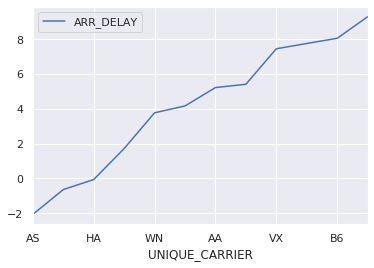

In [22]:
df_train[['ARR_DELAY', 'UNIQUE_CARRIER']].groupby('UNIQUE_CARRIER').mean().sort_values(by='ARR_DELAY', ascending=True).plot()

In [23]:
list_carriers_mean_ordered = df_train[['ARR_DELAY', 'UNIQUE_CARRIER']].groupby('UNIQUE_CARRIER').mean().sort_values(by='ARR_DELAY', ascending=True).index.tolist()

In [24]:
list_carriers_mean_ordered_dict = {list_carriers_mean_ordered[i] : i for i in range(len(list_carriers_mean_ordered))  }

In [25]:
list_carriers_mean_ordered_mapper = lambda k : list_carriers_mean_ordered_dict[k]

In [26]:
#df = df.loc[df_train.index]

# Features encoding

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn import decomposition
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import statistics

from scipy import sparse

'''
Cette fonction fait un 1 hot encoding des features qui sont des catégories
Old function not used anymore
'''
    
def add_categorical_features_1hot(df, categorical_features_totransform):
    #df.drop(labels=categorical_features_totransform, axis=1, inplace=True)
    
    
    #df_encoded = pd.get_dummies(df, columns=categorical_features_totransform, sparse=True)
    
    for feature_totransform in categorical_features_totransform:
        print(f'Adding 1hot Feature : {feature_totransform}')
        
        print('First')
        df_transformed = df[feature_totransform].str.get_dummies().add_prefix(feature_totransform +'_')   
        
        #df_new = pd.get_dummies(df, columns=['ORIGIN'])
        
        
        
        
        #df.drop(labels=feature_totransform, axis=1, inplace=True)
        print('Second')
        del df[feature_totransform]
        
        print('Third')
        df = pd.concat([df, df_transformed], axis=1)
        
    return(df)


class HHMM_to_Minutes(BaseEstimator, TransformerMixin):
    def __init__(self, features_toconvert = ['CRS_DEP_TIME', 'CRS_ARR_TIME']):
        self.features_toconvert = features_toconvert
        return None
    
    def fit(self, df):      
        return self
    
    def transform(self, df):       
        for feature_toconvert in self.features_toconvert:
            print(f'Converting feature {feature_toconvert}\n')
            #print('1\n')
            df_concat = pd.concat([df[feature_toconvert].str.slice(start=0,stop=2, step=1),df[feature_toconvert].str.slice(start=2,stop=4, step=1)], axis=1).astype(int).copy(deep=True)
                    
            #print('2\n')
            df[feature_toconvert] = (df_concat.iloc[:, [0]] * 60 + df_concat.iloc[:, [1]])[feature_toconvert]
            
            #print('3\n')
        
        return(df)

    
'''
class CategoricalFeatures1HotEncoder_old(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features_totransform=['ORIGIN', 'UNIQUE_CARRIER', 'DEST']):
        self.categorical_features_totransform = categorical_features_totransform
    
    def fit(self, df, labels=None):      
        return self
    
    def transform(self, df):
        # /!\ Array will not have the same shape if we fit an ensemble of samples that have less values than total dataset
        df_encoded = pd.get_dummies(df, columns=self.categorical_features_totransform, sparse=True)  # Sparse allows to gain memory. But then, standardscale must be with_mean=False
        #df_encoded = pd.get_dummies(df, columns=self.categorical_features_totransform, sparse=False)
        print('type of df : ' + str(type(df_encoded)))
        return(df_encoded)
'''

class CategoricalFeatures1HotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features_totransform=['ORIGIN', 'UNIQUE_CARRIER', 'DEST']):
        self.categorical_features_totransform = categorical_features_totransform
        self.fitted = False
        self.all_feature_values = {}
        #self.df_encoded = None
    
    def fit(self, df, labels=None):      
        print('Fit data')
        for feature_name in self.categorical_features_totransform:
            self.all_feature_values[feature_name] = feature_name + '_' + df[feature_name].unique()
        
        self.fitted = True
        
        return self
    
    def transform(self, df):
        if (self.fitted == False):
            self.fit(df)
        
        print('Transform data')
        print('1hot encode categorical features...')
        df_encoded = pd.get_dummies(df, columns=self.categorical_features_totransform, sparse=True)  # Sparse allows to gain memory. But then, standardscale must be with_mean=False
        #df_encoded = pd.get_dummies(df, columns=self.categorical_features_totransform, sparse=False)
        
        # Get category values that were in fitted data, but that are not in data to transform 
        for feature_name, feature_values in self.all_feature_values.items():
            diff_columns = list(set(feature_values) - set(df_encoded.columns.tolist()))
            print(f'Column values that were in fitted data but not in current data: {diff_columns}')
        
            if (len(diff_columns) > 0):
                print('Adding those column with 0 values to the DataFrme...')
                # Create columns with 0 for the above categories, in order to preserve same matrix shape between train et test set
                zeros_dict = dict.fromkeys(diff_columns, 0)
                df_encoded.assign(**zeros_dict)
        
        print('type of df : ' + str(type(df_encoded)))
        return(df_encoded)
    

class Aggregate_then_GroupByMean_then_Sort_numericalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features_totransform=['ORIGIN', 'UNIQUE_CARRIER', 'DEST']):
        self.categorical_features_totransform = categorical_features_totransform
        self.fitted = False
        self.all_feature_values = {}
    
    def fit(self, df, labels=None):      
        print('Fit data')
        
        self.feature_maps = {}
        
        for feature_name in self.categorical_features_totransform:
            print(f'Fitting feature {feature_name}')
            # List all feature values ordered by mean delay
            list_feature_mean_ordered = df[['ARR_DELAY', feature_name]].groupby(feature_name).mean().sort_values(by='ARR_DELAY', ascending=True).index.tolist()
            
            # Generate a dictionary of feature values as keys and index as values
            self.feature_maps[feature_name] = {}
            self.feature_maps[feature_name]['list_feature_mean_ordered_dict'] = {list_feature_mean_ordered[i] : i for i in range(len(list_feature_mean_ordered))  }
            
            #print('Dictionnary : ' + str(self.feature_maps[feature_name]['list_feature_mean_ordered_dict']))
            
            # BUG : we had to do that line of code in transform instead, not in fit (result is the same, no difference)
            #self.feature_maps[feature_name]['list_feature_mean_ordered_mapper'] = lambda k : self.feature_maps[feature_name]['list_feature_mean_ordered_dict'][k]
                  
        self.fitted = True
        
        return self
    
    def transform(self, df):
        if (self.fitted == False):
            print('Launching fit first (if you see this message : ensure that you have passed training set as input, not test set)')
            self.fit(df)
        
        print('Encode categorical features...')
        
        for feature_name in self.categorical_features_totransform:
            print(f'Encoding feature {feature_name} ...')
            #print('Dictionnary : ' + str(self.feature_maps[feature_name]['list_feature_mean_ordered_dict']))
            
            # Replace each feature value by its index (the lowest the index, the lowest the mean delay is for this feature)
            list_feature_mean_ordered_mapper = lambda k : self.feature_maps[feature_name]['list_feature_mean_ordered_dict'][k]
                            
            #df[feature_name] = df.loc[:, feature_name].apply(self.feature_maps[feature_name]['list_feature_mean_ordered_mapper'])  # BUG (we had to use line below instead)
            df[feature_name] = df.loc[:, feature_name].apply(list_feature_mean_ordered_mapper)

        return(df)
    
    
class FeaturesSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features_toselect = None):  # If None : every column is kept, nothing is done
        self.features_toselect = features_toselect
    
    def fit(self, df, labels=None):      
        return self
    
    def transform(self, df):       
        if (self.features_toselect != None):
            filter_cols = [col for col in df if (col.startswith(tuple(self.features_toselect)))]
            
            print("Features selected (in order): " + str(df[filter_cols].columns))
            
            return(df[filter_cols])    

        else:
            return(df)

'''
In order have less features globally: we Keep only features_tofilter that represent percent_tokeep% of total values
Features which values represent less than percent_tokeep% will be set "OTHERS" value instead of their real value
'''

class Filter_High_Percentile(BaseEstimator, TransformerMixin):
    def __init__(self, features_tofilter = ['ORIGIN', 'DEST'], percent_tokeep = 80):
        self.features_tofilter = features_tofilter
        self.percent_tokeep = percent_tokeep
        self.high_percentile = None
        self.low_percentile = None
    
    def fit(self, df, labels=None): 
        print('Fit high percentile filter...')
        for feature_tofilter in self.features_tofilter:
            # Get feature_tofilter values that represent 80% of data
            self.high_percentile = ((((df[[feature_tofilter]].groupby(feature_tofilter).size() / len(df)).sort_values(ascending=False)) * 100).cumsum() < self.percent_tokeep).where(lambda x : x == True).dropna().index.values.tolist()
            self.low_percentile = ((((df[[feature_tofilter]].groupby(feature_tofilter).size() / len(df)).sort_values(ascending=False)) * 100).cumsum() >= self.percent_tokeep).where(lambda x : x == True).dropna().index.values.tolist()

            total = len(df[feature_tofilter].unique())
            high_percentile_sum = len(self.high_percentile)
            low_percentile_sum = len(self.low_percentile)
            high_low_sum = high_percentile_sum + low_percentile_sum

            print(f'Total number of {feature_tofilter} values : {total}')
            print(f'Number of {feature_tofilter} high percentile (> {self.percent_tokeep}%) values : {high_percentile_sum}')
            print(f'Number of {feature_tofilter} low percentile values : {low_percentile_sum}')
            print(f'Sum of high percentile + low percentile values : {high_low_sum}')
        
        return self
    
    def transform(self, df):       
        if (self.features_tofilter != None):
            print('Apply high percentile filter...')
            
            for feature_tofilter in self.features_tofilter:
                df.loc[df[feature_tofilter].isin(self.low_percentile), feature_tofilter] = 'OTHERS'   
            
            return(df)    

        else:
            return(df)
        

    
class DenseToSparseConverter(BaseEstimator, TransformerMixin):
    def __init__(self):  # If None : every column is kept, nothing is done
        return None
    
    def fit(self, matrix, labels=None):      
        return self
    
    def transform(self, matrix):   
        return(sparse.csr_matrix(matrix))

    
'''
This class adds polynomial features in univariate way  (if feature X and n_degree 3 :  then it will add X², X³, and an intercept at the end)
'''    
class PolynomialFeaturesUnivariateAdder(BaseEstimator, TransformerMixin):
    def __init__(self, n_degrees=2):
        self.n_degrees = n_degrees
        self.fitted = False
    
    def fit(self, df, labels=None):              
        return self
    
    def transform(self, df):
        if (self.fitted == False):
            self.fit(df)

        nb_instances, n_features = df.shape
        df_poly = np.empty((nb_instances, 0)) # Create empty array of nb_instances line and 0 features yet (we'll concatenate polynomial features to it)

        progbar = tqdm(range(n_features))
        print('Adding polynomial features')

        for feature_index in range(n_features):    
            df_1feature = df[:,feature_index]  # Reshape 

            for n_degree in range(self.n_degrees):
                df_poly = np.c_[df_poly, np.power(df_1feature, n_degree + 1)]

            progbar.update(1)

        # Add bias (intercept)
        df_poly = np.c_[df_poly, np.ones((len(df_poly), 1))]  # add x0 = 1 feature        
        
        return(df_poly)
        
    

        
'''
conversion_pipeline = Pipeline([
    ('data_converter', HHMM_to_Minutes()),
    #('categoricalfeatures_1hotencoder', CategoricalFeatures1HotEncoder()),
    #('standardscaler', preprocessing.StandardScaler()),
])
'''

preparation_pipeline = Pipeline([
    ('filter_highpercentile', Filter_High_Percentile()),
    ('data_converter', HHMM_to_Minutes()),
    ('categoricalfeatures_1hotencoder', CategoricalFeatures1HotEncoder()),
    #('standardscaler', preprocessing.StandardScaler()),
])


preparation_pipeline_meansort = Pipeline([
    #('filter_highpercentile', Filter_High_Percentile()),
    ('data_converter', HHMM_to_Minutes()),
    ('numericalEncoder', Aggregate_then_GroupByMean_then_Sort_numericalEncoder()),
    #('standardscaler', preprocessing.StandardScaler()),
])


# If matrix is sparse, with_mean=False must be passed to StandardScaler
prediction_pipeline = Pipeline([
    ('features_selector', FeaturesSelector(features_toselect=['ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME'])),
    ('standardscaler', ColumnTransformer([
        ('standardscaler_specific', StandardScaler(), ['CRS_DEP_TIME','MONTH','DAY_OF_MONTH', 'DAY_OF_WEEK', 'CRS_ARR_TIME', 'DISTANCE', 'CRS_ELAPSED_TIME'])
    ], remainder='passthrough', sparse_threshold=1)),
    
    ('dense_to_sparse_converter', DenseToSparseConverter()),
    #('predictor', To_Complete(predictor_params =  {'n_neighbors':6, 'algorithm':'ball_tree', 'metric':'minkowski'})),
])
#copy=False passed to StandardScaler() allows to gain memory



prediction_pipeline_without_sparse = Pipeline([
    ('features_selector', FeaturesSelector(features_toselect=['ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME'])),
    ('standardscaler', ColumnTransformer([
        ('standardscaler_specific', StandardScaler(), ['CRS_DEP_TIME','MONTH','DAY_OF_MONTH', 'DAY_OF_WEEK', 'CRS_ARR_TIME', 'DISTANCE', 'CRS_ELAPSED_TIME'])
    ], remainder='passthrough', sparse_threshold=1)),
    
    #('dense_to_sparse_converter', DenseToSparseConverter()),
    #('predictor', To_Complete(predictor_params =  {'n_neighbors':6, 'algorithm':'ball_tree', 'metric':'minkowski'})),
])

'''
# Old code that used scikit learn OneHotEncoder (which does not keep DataFrame type) instead of Pandas
preparation_pipeline2 = Pipeline([
    ('data_converter', HHMM_to_Minutes()),
    ('multiple_encoder', ColumnTransformer([
        ('categoricalfeatures_1hotencoder', OneHotEncoder(), ['ORIGIN', 'UNIQUE_CARRIER', 'DEST'])
    ], remainder='passthrough')),
    #('standardscaler', preprocessing.StandardScaler()),
])
'''

'''
ColumnTransformer([
        ('standardscaler_specific', StandardScaler(), ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT'])
    ], remainder='passthrough')
'''

"\nColumnTransformer([\n        ('standardscaler_specific', StandardScaler(), ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT'])\n    ], remainder='passthrough')\n"

In [28]:
df_train_transformed = preparation_pipeline.fit_transform(df_train)

Fit high percentile filter...
Total number of ORIGIN values : 308
Number of ORIGIN high percentile (> 80%) values : 45
Number of ORIGIN low percentile values : 263
Sum of high percentile + low percentile values : 308
Total number of DEST values : 308
Number of DEST high percentile (> 80%) values : 45
Number of DEST low percentile values : 263
Sum of high percentile + low percentile values : 308
Apply high percentile filter...
Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Fit data
Transform data
1hot encode categorical features...
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
type of df : <class 'pandas.core.frame.DataFrame'>


In [29]:
df_train_transformed

,CRS_DEP_TIME,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_ARR_TIME,DISTANCE,CRS_ELAPSED_TIME,ARR_DELAY,DEP_DELAY,TAXI_OUT,...,DEST_SAN,DEST_SAT,DEST_SEA,DEST_SFO,DEST_SJC,DEST_SLC,DEST_SMF,DEST_SNA,DEST_STL,DEST_TPA
3352894,937,3,29,2,1109,1056.0,172.0,10.0,1.0,9.0,...,0,0,0,0,0,0,0,0,0,0
1268114,740,6,22,3,909,925.0,169.0,175.0,184.0,23.0,...,0,0,0,0,0,0,0,0,0,0
2193866,815,12,26,1,1023,853.0,148.0,-12.0,5.0,20.0,...,0,0,0,0,0,0,0,0,0,0
3874513,980,1,22,5,1058,763.0,138.0,-16.0,-10.0,9.0,...,0,0,0,0,0,0,0,0,0,0
2213800,450,12,12,1,644,867.0,134.0,53.0,52.0,31.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1570006,835,5,7,6,920,862.0,145.0,13.0,5.0,16.0,...,0,0,0,0,0,0,0,0,0,0
2234489,1045,12,13,2,1370,1476.0,205.0,-12.0,-5.0,11.0,...,0,0,0,0,0,0,0,0,0,0
4926484,615,11,11,5,990,2007.0,255.0,-5.0,1.0,20.0,...,0,0,0,0,0,0,0,0,0,0
4304572,1190,10,4,2,1275,224.0,85.0,-15.0,-2.0,18.0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df_train_transformed.shape

(4993045, 115)

In [31]:
df_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4993045 entries, 3352894 to 1692743
Columns: 115 entries, CRS_DEP_TIME to DEST_TPA
dtypes: Sparse[uint8, 0](104), float64(5), int64(5), object(1)
memory usage: 528.6+ MB


In [32]:
df_train_transformed = prediction_pipeline.fit_transform(df_train_transformed)

Features selected (in order): Index(['CRS_DEP_TIME', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'CRS_ARR_TIME',
       'DISTANCE', 'CRS_ELAPSED_TIME', 'ORIGIN_ATL', 'ORIGIN_AUS',
       'ORIGIN_BNA',
       ...
       'DEST_SAN', 'DEST_SAT', 'DEST_SEA', 'DEST_SFO', 'DEST_SJC', 'DEST_SLC',
       'DEST_SMF', 'DEST_SNA', 'DEST_STL', 'DEST_TPA'],
      dtype='object', length=111)


In [35]:
df_train_transformed.shape

(4993045, 111)

In [37]:
from scipy import sparse
sparse.issparse(df_train_transformed)

True

In [38]:
#pd.DataFrame.sparse.from_spmatrix(df_train_transformed)

In [40]:
pd.set_option('display.max_columns', 400)

In [41]:
all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



# Test set encoding

In [42]:
df_test_transformed = preparation_pipeline.transform(df_test)
df_test_transformed = prediction_pipeline.transform(df_test_transformed)
df_test_transformed.shape

Apply high percentile filter...
Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Transform data
1hot encode categorical features...
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
type of df : <class 'pandas.core.frame.DataFrame'>
Features selected (in order): Index(['CRS_DEP_TIME', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'CRS_ARR_TIME',
       'DISTANCE', 'CRS_ELAPSED_TIME', 'ORIGIN_ATL', 'ORIGIN_AUS',
       'ORIGIN_BNA',
       ...
       'DEST_SAN', 'DEST_SAT', 'DEST_SEA', 'DEST_SFO', 'DEST_SJC', 'DEST_SLC',
       'DEST_SMF', 'DEST_SNA', 'DEST_STL', 'DEST_TPA'],
      dtype='object', length=111)


(554783, 111)

# Linear regression

In [43]:
df_train[model1_label].shape

(4993045,)

In [44]:


if (EXECUTE_INTERMEDIATE_MODELS == True):
    lin_reg = LinearRegression()
    lin_reg.fit(df_train_transformed, df_train[model1_label])

In [45]:


if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = lin_reg.predict(df_test_transformed)
    lin_mse = mean_squared_error(df_test[model1_label], df_test_predictions)
    lin_rmse = np.sqrt(lin_mse)
    lin_rmse



=> 42.17  (42.16679389006135)

In [48]:
df_train_transformed.shape[0]

4993045

Starting learning curve for 50 iterations


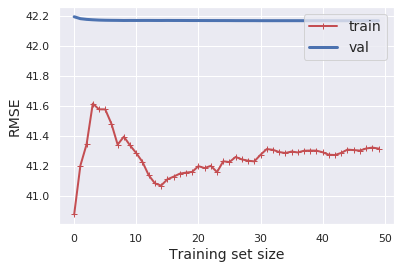

In [53]:
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], 100000)

In [60]:
df_train

,ORIGIN,CRS_DEP_TIME,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,DEST,CRS_ARR_TIME,DISTANCE,CRS_ELAPSED_TIME,ARR_DELAY,DEP_DELAY,TAXI_OUT,TAIL_NUM
3352894,OTHERS,937,3,29,2,B6,OTHERS,1109,1056.0,172.0,10.0,1.0,9.0,N339JB
1268114,ORD,740,6,22,3,UA,IAH,909,925.0,169.0,175.0,184.0,23.0,N79402
2193866,SAN,815,12,26,1,UA,DEN,1023,853.0,148.0,-12.0,5.0,20.0,N17244
3874513,OTHERS,980,1,22,5,OO,LAX,1058,763.0,138.0,-16.0,-10.0,9.0,N785SK
2213800,ORD,450,12,12,1,UA,BOS,644,867.0,134.0,53.0,52.0,31.0,N801UA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1570006,DEN,835,5,7,6,WN,LAX,920,862.0,145.0,13.0,5.0,16.0,N455WN
2234489,SFO,1045,12,13,2,VX,DAL,1370,1476.0,205.0,-12.0,-5.0,11.0,N625VA
4926484,IAH,615,11,11,5,UA,OTHERS,990,2007.0,255.0,-5.0,1.0,20.0,N67812
4304572,IAH,1190,10,4,2,UA,DFW,1275,224.0,85.0,-15.0,-2.0,18.0,N834UA


In [73]:
df_train_transformed[0, :].toarray()

array([[ 0.43581297, -1.02983686,  1.49760716, -0.97158642,  0.65654655,
         0.33337247,  0.34881055,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [75]:
df_train[[model1_label]]

,ARR_DELAY
3352894,10.0
1268114,175.0
2193866,-12.0
3874513,-16.0
2213800,53.0
...,...
1570006,13.0
2234489,-12.0
4926484,-5.0
4304572,-15.0


In [43]:
lin_reg.coef_

array([  3.0601343 ,   0.54106613,   0.49255945,  -0.02052923,
         1.6354574 ,  10.62073489, -12.18551101,   0.27450354,
        -1.33980503,   0.10149764,   0.31685657,  -0.65541914,
        -1.53379643,  -0.56033462,   2.17482374,   0.23276129,
        -1.26869889,   3.05226253,   0.18607054,   5.51988916,
         1.42903568,  -4.32234874,   0.30318026,  -0.94593642,
        -1.40645942,   4.27814774,  -0.06934268,   2.69507292,
         4.87336364,  -1.91588117,   1.21284379,  -1.94274921,
         4.73238555,  -3.20774291,   0.47564597,  -1.6987073 ,
         0.14379464,   4.40476573,  -1.74618153,  -2.76805405,
         0.45234394,  -1.60170948,   1.1685909 ,  -2.46122663,
        -1.75186943,  -0.42718454,   3.2389558 ,  -0.80286191,
        -3.11232599,  -0.71881518,  -3.40806787,  -1.02946792,
        -0.57180507,   0.58845347,  -5.32955616,   4.14911968,
        -3.77501356,   1.94734073,   5.04213062,  -3.46294331,
         4.36932467,   1.10828485,  -3.07715486,  -2.15

array([  3.0601343 ,   0.54106613,   0.49255945,  -0.02052923,
         1.6354574 ,  10.62073489, -12.18551101,   0.27450354,
        -1.33980503,   0.10149764,   0.31685657,  -0.65541914,
        -1.53379643,  -0.56033462,   2.17482374,   0.23276129,
        -1.26869889,   3.05226253,   0.18607054,   5.51988916,
         1.42903568,  -4.32234874,   0.30318026,  -0.94593642,
        -1.40645942,   4.27814774,  -0.06934268,   2.69507292,
         4.87336364,  -1.91588117,   1.21284379,  -1.94274921,
         4.73238555,  -3.20774291,   0.47564597,  -1.6987073 ,
         0.14379464,   4.40476573,  -1.74618153,  -2.76805405,
         0.45234394,  -1.60170948,   1.1685909 ,  -2.46122663,
        -1.75186943,  -0.42718454,   3.2389558 ,  -0.80286191,
        -3.11232599,  -0.71881518,  -3.40806787,  -1.02946792,
        -0.57180507,   0.58845347,  -5.32955616,   4.14911968,
        -3.77501356,   1.94734073,   5.04213062,  -3.46294331,
         4.36932467,   1.10828485,  -3.07715486,  -2.1540515 ,
         0.59406537,  -0.21559221,  -1.4864192 ,  -1.92685958,
        -1.13360134,  -2.79307414,  -3.16535316,  -2.14418489,
        -0.3786179 ,  -1.35651547,  -0.65089003,   3.72717084,
        -0.5316482 ,   6.38411318,   0.56280763,   2.32285819,
        -0.71875407,  -3.7427498 ,  -0.72443612,   3.01913525,
         0.0259135 ,   6.05048444,   6.88297842,  -2.05348981,
         0.57619293,  -3.06150148,   2.91489312,  -3.69821352,
         1.39265583,  -2.73996445,   0.48819288,   3.78111808,
        -2.73090349,  -0.99799275,  -1.41459568,  -0.14998697,
        -1.16199228,  -1.2855059 ,  -2.33902093,   2.26562809,
         9.46369559,  -0.27437885,  -1.82963879,   0.47213692,
        -2.5256052 ,  -2.053249  ,  -1.04523965])

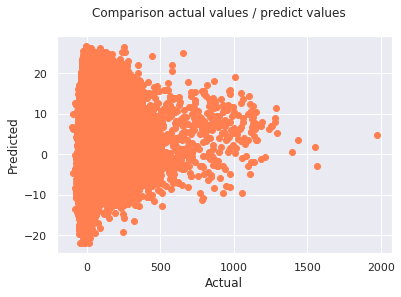

In [56]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_test[model1_label], df_test_predictions, color='coral')

In [39]:
from sklearn.model_selection import cross_validate

#scores = cross_validate(lin_reg, df_train_transformed, df_train[model1_label], scoring='neg_root_mean_squared_error', cv=5)

In [40]:
#scores['test_score'].mean()

# ElasticNET regression

In [48]:
from sklearn.model_selection import ShuffleSplit


shuffled_split_train = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)


In [49]:
from sklearn.linear_model import ElasticNet

In [50]:
from sklearn.model_selection import GridSearchCV

eNet = ElasticNet()

grid_search = GridSearchCV(eNet, param_grid = {"max_iter": [1, 5, 10],
                      "alpha": [10, 100],
                      "l1_ratio": np.arange(0.0, 1.0, 0.4)},cv=shuffled_split_train, scoring='neg_mean_squared_error', error_score=np.nan, verbose=2)

In [51]:
'''
from sklearn.model_selection import GridSearchCV

eNet = ElasticNet()

grid_search = GridSearchCV(eNet, param_grid = {"max_iter": [1, 5, 10],
                      "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                      "l1_ratio": np.arange(0.0, 1.0, 0.1)},cv=shuffled_split_train, scoring='neg_mean_squared_error', error_score=np.nan, verbose=2)
'''

'\nfrom sklearn.model_selection import GridSearchCV\n\neNet = ElasticNet()\n\ngrid_search = GridSearchCV(eNet, param_grid = {"max_iter": [1, 5, 10],\n                      "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],\n                      "l1_ratio": np.arange(0.0, 1.0, 0.1)},cv=shuffled_split_train, scoring=\'neg_mean_squared_error\', error_score=np.nan, verbose=2)\n'

In [52]:
if (RECOMPUTE_GRIDSEARCH == True):
    grid_search.fit(df_train_transformed, df_train[model1_label])

In [53]:
grid_search, df_grid_search_results = save_or_load_search_params(grid_search, 'eNet_20200319')

In [54]:
df_grid_search_results.sort_values(by='mean_test_score', ascending=False)

,alpha,l1_ratio,max_iter,mean_test_score,std_test_score,mean_fit_time,mean_score_time
0,10,0.0,1,-1741.474494,11.553554,8.451748,0.021589
2,10,0.0,10,-1741.606988,11.553293,19.897743,0.017433
1,10,0.0,5,-1741.606988,11.553293,11.345686,0.018125
9,100,0.0,1,-1746.266246,11.555358,3.253050,0.018168
10,100,0.0,5,-1746.268263,11.555355,10.535562,0.017086
11,100,0.0,10,-1746.268263,11.555355,19.410727,0.016518
4,10,0.4,5,-1746.670284,11.555964,3.243109,0.018928
5,10,0.4,10,-1746.670284,11.555964,3.316887,0.018247
3,10,0.4,1,-1746.670284,11.555964,2.742426,0.017680
6,10,0.8,1,-1746.913947,11.555634,2.613709,0.016329


In [55]:
np.sqrt(1741.47)

41.73092378560532

=> 41.73092378560532

In [56]:
grid_search.best_estimator_

ElasticNet(alpha=10, copy_X=True, fit_intercept=True, l1_ratio=0.0, max_iter=1,
           normalize=False, positive=False, precompute=False, random_state=None,
           selection='cyclic', tol=0.0001, warm_start=False)

In [60]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = grid_search.best_estimator_.predict(df_test_transformed)
    mse = mean_squared_error(df_test[model1_label], df_test_predictions)
    rmse = np.sqrt(mse)
    rmse


In [65]:
grid_search.best_estimator_.coef_

array([ 3.81842241e-01,  5.38463257e-02,  4.20287224e-02,  5.22019019e-04,
        3.01660130e-01, -5.81861174e-02, -6.72278997e-02, -1.27034969e-02,
       -2.24325259e-04,  4.09514301e-04, -3.70631003e-03, -2.53436510e-03,
       -7.75208542e-04,  9.33417957e-05,  4.17993863e-03, -9.42512871e-04,
       -1.11806550e-03,  1.44798574e-02, -3.13856400e-03,  3.29966151e-03,
        3.99529584e-03, -4.48915797e-03,  1.95911581e-03, -2.36326646e-03,
       -4.08853652e-03,  1.66741438e-03,  5.08260117e-03,  1.27353349e-02,
        9.28815390e-04, -1.23422335e-03,  3.00267997e-03, -1.85353662e-03,
        6.23418838e-03, -1.61411894e-03, -2.91269348e-03, -6.75664468e-04,
        1.69775346e-03,  1.63447325e-02, -2.33087459e-02, -2.59028581e-03,
       -1.74542702e-03, -1.45041347e-04,  6.16849621e-05, -9.03449295e-04,
       -5.89810820e-04, -5.62947068e-03,  9.74750809e-03,  2.35807415e-04,
       -6.16562051e-03,  9.79361758e-04, -9.11503285e-04,  2.40351790e-04,
       -8.00703606e-04,  

array([ 3.81842241e-01,  5.38463257e-02,  4.20287224e-02,  5.22019019e-04,
        3.01660130e-01, -5.81861174e-02, -6.72278997e-02, -1.27034969e-02,
       -2.24325259e-04,  4.09514301e-04, -3.70631003e-03, -2.53436510e-03,
       -7.75208542e-04,  9.33417957e-05,  4.17993863e-03, -9.42512871e-04,
       -1.11806550e-03,  1.44798574e-02, -3.13856400e-03,  3.29966151e-03,
        3.99529584e-03, -4.48915797e-03,  1.95911581e-03, -2.36326646e-03,
       -4.08853652e-03,  1.66741438e-03,  5.08260117e-03,  1.27353349e-02,
        9.28815390e-04, -1.23422335e-03,  3.00267997e-03, -1.85353662e-03,
        6.23418838e-03, -1.61411894e-03, -2.91269348e-03, -6.75664468e-04,
        1.69775346e-03,  1.63447325e-02, -2.33087459e-02, -2.59028581e-03,
       -1.74542702e-03, -1.45041347e-04,  6.16849621e-05, -9.03449295e-04,
       -5.89810820e-04, -5.62947068e-03,  9.74750809e-03,  2.35807415e-04,
       -6.16562051e-03,  9.79361758e-04, -9.11503285e-04,  2.40351790e-04,
       -8.00703606e-04,  2.80040048e-02, -1.62362534e-02,  2.32015532e-02,
       -7.01852245e-02,  1.65919140e-02,  7.25363024e-03, -4.83051956e-03,
        1.41858822e-02,  6.85437437e-03, -1.58676117e-02,  4.82723839e-03,
        6.33969777e-03, -2.46758789e-02,  2.42193209e-04, -1.45870754e-04,
        4.15867207e-03, -2.83023087e-03,  7.62388260e-05, -4.24610507e-03,
        5.26083293e-04,  1.47810804e-03, -9.19516190e-03,  8.25254437e-03,
       -5.18481866e-03,  1.03654765e-02,  2.87040417e-03, -1.10418835e-03,
        9.52434223e-05, -2.21408556e-03, -6.79991381e-03,  6.17574698e-03,
       -8.83819104e-04,  1.25073748e-02,  1.17980381e-02, -6.81557286e-04,
        3.04168241e-03, -4.21957706e-03,  3.05120532e-03, -7.89844324e-04,
       -2.93426593e-03, -8.38652464e-04,  1.05935638e-03,  6.74906118e-03,
       -5.14042339e-03, -2.37742304e-03, -4.46900931e-04, -2.72629361e-03,
        9.62469273e-04, -1.57391539e-03, -1.61121536e-05, -5.49546918e-03,
        1.91647269e-02, -4.83097086e-05, -6.78384591e-03,  1.00960720e-03,
       -2.12687675e-03, -2.30717357e-04,  1.28182126e-04])

In [51]:
from sklearn import metrics 
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

## Naive approach

### Random value between min and max

In [52]:
y_pred_random = np.random.randint(df['ARR_DELAY'].min(), df['ARR_DELAY'].max(), df_test['ARR_DELAY'].shape)
naive_mse = mean_squared_error(df_test[model1_label], y_pred_random)
naive_rmse = np.sqrt(naive_mse)
naive_rmse

1191.3536427817378

### Always mean naive approach

In [86]:
from sklearn import dummy

dum = dummy.DummyRegressor(strategy='mean')

# Entraînement
dum.fit(df_train_transformed, df_train[model1_label])

# Prédiction sur le jeu de test
y_pred_dum = dum.predict(df_test_transformed)

# Evaluate
print("RMSE : {:.2f}".format(np.sqrt(mean_squared_error(df_test[model1_label], y_pred_dum)) ))
print("MAE : {:.2f}".format(np.sqrt(mean_absolute_error(df_test[model1_label], y_pred_dum)) ))


RMSE : 41.77
MAE : 4.63


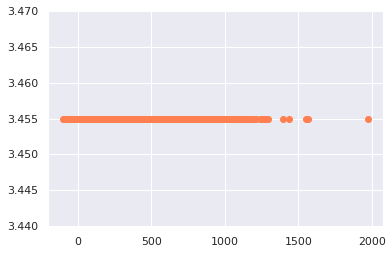

In [54]:
plt.scatter(df_test[model1_label], y_pred_dum, color='coral')

In [55]:
df_test[model1_label]

3746453    62.0
1300593   -22.0
4707023   -11.0
1752505   -38.0
2152691    -1.0
           ... 
2882585    -8.0
298857     -7.0
4799315     5.0
5392696     7.0
236730     -4.0
Name: ARR_DELAY, Length: 554783, dtype: float64

In [56]:
y_pred_dum

array([3.45500812, 3.45500812, 3.45500812, ..., 3.45500812, 3.45500812,
       3.45500812])

In [57]:
df['ARR_DELAY'].abs().mean()

20.15843930273253

=> With all samples and 70% most represented features, without StandardScale :  on test set : lin_rmse = 42.17  
=> With all samples and 80% most represented features, without StandardScale :  on test set : lin_rmse = 42.16  
=> With all samples and 80% most represented features, with StandardScale :  on test set : lin_rmse = 42.16

# Random forest

In [58]:
from sklearn.ensemble import RandomForestRegressor

if (EXECUTE_INTERMEDIATE_MODELS == True):
    random_reg = RandomForestRegressor(n_estimators=10, max_depth=2, random_state=42)
    random_reg.fit(df_train_transformed, df_train[model1_label])

In [59]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = random_reg.predict(df_test_transformed)
    mse = mean_squared_error(df_test[model1_label], df_test_predictions)
    rmse = np.sqrt(mse)
    rmse


=> 42.373691516139964

# SVM

In [60]:
'''
from sklearn.svm import SVR

svm_reg = SVR(kernel="rbf", verbose=True)
svm_reg.fit(df_train_transformed, df_train[model1_label])
'''

'\nfrom sklearn.svm import SVR\n\nsvm_reg = SVR(kernel="rbf", verbose=True)\nsvm_reg.fit(df_train_transformed, df_train[model1_label])\n'

In [67]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(random_state=42, tol=1e-5, verbose=True)

if (EXECUTE_INTERMEDIATE_MODELS == True):
    svm_reg.fit(df_train_transformed, df_train[model1_label])

In [62]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    evaluate_model(svm_reg, df_test_transformed, df_test[model1_label])

=> RMSE : 43.45607643335432

In [68]:
grid_search_SVR = GridSearchCV(svm_reg, param_grid = {"epsilon": [0, 0.5],
                              "C": [1, 5, 10, 100, 1000],
                              "loss": ['epsilon_insensitive', 'squared_epsilon_insensitive'],},cv=shuffled_split_train, scoring='neg_mean_squared_error', error_score=np.nan, verbose=2)

In [69]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    if (RECOMPUTE_GRIDSEARCH == True):
        grid_search_SVR.fit(df_train_transformed, df_train[model1_label])

=> Warning at execution : /home/francois/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)  

In [70]:
grid_search_SVR, df_grid_search_results = save_or_load_search_params(grid_search_SVR, 'LinearSVR_20200319')

In [71]:
df_grid_search_results.sort_values(by='mean_test_score', ascending=False)

,C,epsilon,loss,mean_test_score,std_test_score,mean_fit_time,mean_score_time
1,1,0.0,squared_epsilon_insensitive,-1709.197402,11.709555,1122.307692,0.036019
3,1,0.5,squared_epsilon_insensitive,-1709.244359,11.702259,1070.694849,0.021828
5,5,0.0,squared_epsilon_insensitive,-1709.572593,11.470917,1055.509449,0.022631
7,5,0.5,squared_epsilon_insensitive,-1709.621480,11.463629,1050.236998,0.023208
9,10,0.0,squared_epsilon_insensitive,-1715.010698,12.839219,1056.915728,0.022069
11,10,0.5,squared_epsilon_insensitive,-1715.049010,12.840819,1047.752463,0.023156
8,10,0.0,epsilon_insensitive,-1814.960137,12.048914,247.978703,0.022987
6,5,0.5,epsilon_insensitive,-1815.410220,11.888318,157.402844,0.022296
2,1,0.5,epsilon_insensitive,-1815.462776,11.828610,42.894303,0.022394
0,1,0.0,epsilon_insensitive,-1815.600737,11.898766,43.644705,0.022400


In [72]:
np.sqrt(1709.197402)

41.34244068750659

In [73]:
grid_search_SVR.best_estimator_

LinearSVR(C=1, dual=True, epsilon=0, fit_intercept=True, intercept_scaling=1.0,
          loss='squared_epsilon_insensitive', max_iter=1000, random_state=0,
          tol=1e-05, verbose=True)

In [74]:
evaluate_model(grid_search_SVR.best_estimator_, df_test_transformed, df_test[model1_label])

RMSE : 42.166794620090805


=> Best estimator :  inearSVR(C=1, dual=True, epsilon=0, fit_intercept=True, intercept_scaling=1.0,
          loss='squared_epsilon_insensitive', max_iter=1000, random_state=0,
          tol=1e-05, verbose=True)  

=> RMSE : 42.16

# Polynomial features + linear regression

In [32]:
df_train_transformed

<4993045x111 sparse matrix of type '<class 'numpy.float64'>'
	with 49930450 stored elements in Compressed Sparse Row format>

In [33]:
poly = ColumnTransformer([
                                ('poly', PolynomialFeatures(degree=2), [0, 1, 2, 3, 4, 5, 6])     
                                ], remainder='passthrough', sparse_threshold=1)

#poly.fit(df_train_transformed, df_train[model1_label])
#poly.fit(df_train_transformed)

In [34]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_train_transformed = poly.fit_transform(df_train_transformed)
    df_test_transformed = poly.transform(df_test_transformed)

In [33]:
df_train_transformed.shape

(4993045, 140)

In [36]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    lin_reg = LinearRegression()
    lin_reg.fit(df_train_transformed, df_train[model1_label])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [41]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

RMSE : 42.11719088178065


=> 42.11719088178065

# Polynomial features + random forest

In [43]:
from sklearn.ensemble import RandomForestRegressor

if (EXECUTE_INTERMEDIATE_MODELS == True):
    random_reg = RandomForestRegressor(n_estimators=10, max_depth=2, random_state=42)
    random_reg.fit(df_train_transformed, df_train[model1_label])

In [44]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = random_reg.predict(df_test_transformed)
    evaluate_model(random_reg, df_test_transformed, df_test[model1_label])

RMSE : 42.29092202765607


In [ ]:
'''
#Too slow

from sklearn.ensemble import RandomForestRegressor

if (EXECUTE_INTERMEDIATE_MODELS == True):
    random_reg = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
    random_reg.fit(df_train_transformed, df_train[model1_label])
    
'''

In [ ]:
'''
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = random_reg.predict(df_test_transformed)
    evaluate_model(random_reg, df_test_transformed, df_test[model1_label])
'''

In [78]:
poly = ColumnTransformer([
                                ('poly', PolynomialFeatures(degree=2), [0, 1, 2, 3, 4, 5, 6])     
                                ], remainder='passthrough', sparse_threshold=1)

poly.fit(df_train_transformed, df_train[model1_label])

MemoryError: Unable to allocate array with shape (139805260,) and data type float64

In [ ]:

polynomial_reg = Pipeline([('poly_columntransformer', ColumnTransformer([
                                ('poly', PolynomialFeatures(degree=3), ['CRS_DEP_TIME','MONTH','DAY_OF_MONTH', 'DAY_OF_WEEK', 'CRS_ARR_TIME', 'DISTANCE', 'CRS_ELAPSED_TIME'])     
                                ], remainder='passthrough', sparse_threshold=1)),
                          ('linear', LinearRegression(fit_intercept=False))])

polynomial_reg.fit(df_train_transformed, df_train[model1_label])

In [ ]:


polynomial_reg = Pipeline([('poly', PolynomialFeatures(degree=3)),
                          ('linear', LinearRegression(fit_intercept=False))])

polynomial_reg.fit(df_train_transformed, df_train[model1_label])

In [ ]:
evaluate_model(polynomial_reg, df_test_transformed, df_test[model1_label])

# New try with group by + mean + sort encoding of categorical features
With preparation_pipeline_meansort instead of preparation_pipeline

In [53]:
del df
del df_train
del df_test
del df_train_transformed
del df_test_transformed

In [78]:
df = load_data()

In [79]:
all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



In [80]:
df, df_train, df_test = custom_train_test_split_sample(df)

In [81]:
df_train_transformed = preparation_pipeline_meansort.fit_transform(df_train)
df_train_transformed = prediction_pipeline_without_sparse.fit_transform(df_train_transformed)

df_test_transformed = preparation_pipeline_meansort.transform(df_test)
df_test_transformed = prediction_pipeline_without_sparse.transform(df_test_transformed)
df_test_transformed.shape

Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Fit data
Fitting feature ORIGIN
Fitting feature UNIQUE_CARRIER
Fitting feature DEST
Encode categorical features...
Encoding feature ORIGIN ...
Encoding feature UNIQUE_CARRIER ...
Encoding feature DEST ...
Features selected (in order): Index(['ORIGIN', 'CRS_DEP_TIME', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
       'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'DISTANCE',
       'CRS_ELAPSED_TIME'],
      dtype='object')
Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Encode categorical features...
Encoding feature ORIGIN ...
Encoding feature UNIQUE_CARRIER ...
Encoding feature DEST ...
Features selected (in order): Index(['ORIGIN', 'CRS_DEP_TIME', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
       'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'DISTANCE',
       'CRS_ELAPSED_TIME'],
      dtype='object')


(554783, 10)

In [82]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

RMSE : 41.35589184315079


In [83]:
evaluate_model(lin_reg, df_train_transformed, df_train[model1_label])

RMSE : 41.4491924467758


=> RMSE on training set : 41.35267146874754 (close to RMSE on test set => under fitting)

In [21]:
lin_reg.coef_

array([ 3.00436542,  0.57327962,  0.48739263, -0.02284642,  1.50518474,
        4.62055717, -5.6753519 ,  0.02741956,  0.66220348,  0.02541609])

In [22]:
# Feature importances :
(abs(lin_reg.coef_) / (abs(lin_reg.coef_).sum()))

array([0.18094208, 0.03452656, 0.0293539 , 0.00137596, 0.09065184,
       0.27827948, 0.34180596, 0.00165138, 0.03988212, 0.00153072])

In [23]:
df_train_transformed.shape

(4993045, 10)

In [24]:
df_train_transformed

array([[ 4.35812975e-01, -1.02983686e+00,  1.49760716e+00, ...,
         2.68000000e+02,  1.00000000e+01,  1.96000000e+02],
       [-2.33459447e-01, -1.50981366e-01,  7.02313377e-01, ...,
         2.73000000e+02,  3.00000000e+00,  6.50000000e+01],
       [ 2.13396986e-02,  1.60672962e+00,  1.15676697e+00, ...,
         1.60000000e+02,  3.00000000e+00,  7.80000000e+01],
       ...,
       [-6.58124689e-01,  1.31377779e+00, -5.47433999e-01, ...,
         1.25000000e+02,  3.00000000e+00,  2.10000000e+02],
       [ 1.29533542e+00,  1.02082596e+00, -1.34272778e+00, ...,
         1.25000000e+02,  3.00000000e+00,  2.41000000e+02],
       [ 5.85295140e-01, -4.43933197e-01, -9.29804078e-02, ...,
         2.85000000e+02,  5.00000000e+00,  5.50000000e+01]])

Calculating learning curve for 50 iterations


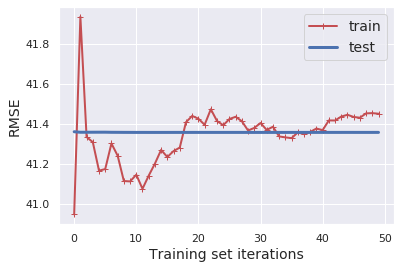

In [84]:
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], 100000)

## Linear Regression with bias

In [26]:
df_train_transformed_bias = np.c_[np.ones((len(df_train_transformed), 1)), df_train_transformed]  # add x0 = 1 to each instance
df_test_transformed_bias = np.c_[np.ones((len(df_test_transformed), 1)), df_test_transformed]  # add x0 = 1 to each instance

In [27]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed_bias, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed_bias)
evaluate_model(lin_reg, df_test_transformed_bias, df_test[model1_label])

RMSE : 42.21335009806042


Calculating learning curve for 50 iterations


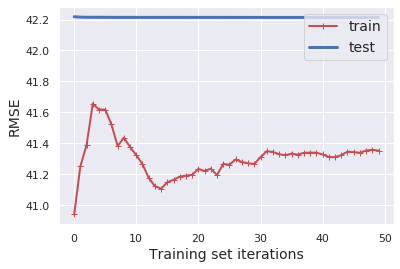

In [28]:
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], 100000)

## Polynomial regression degree 2

In [89]:
poly = PolynomialFeatures(degree=2)
poly.fit(df_train_transformed)
df_train_transformed = poly.transform(df_train_transformed)
df_test_transformed = poly.transform(df_test_transformed)

In [90]:
poly.n_output_features_

66

In [91]:
df_train_transformed.shape

(4993045, 66)

In [92]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    lin_reg = LinearRegression()
    lin_reg.fit(df_train_transformed, df_train[model1_label])

In [93]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

RMSE : 42.12678182212536


=> RMSE on test set : RMSE : 42.12678182212536

In [94]:
evaluate_model(lin_reg, df_train_transformed, df_train[model1_label])

RMSE : 41.26055791264713


=> RMSE on training set : 41.26055791264713

Calculating learning curve for 50 iterations


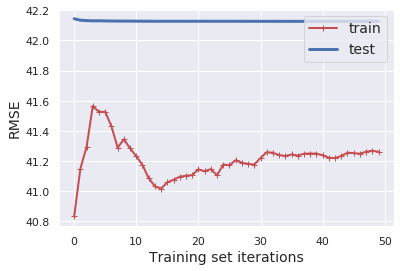

In [95]:
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], 100000)

In [90]:
# Feature importances :
(abs(lin_reg.coef_) / (abs(lin_reg.coef_).sum()))

array([4.84121607e-16, 4.82398170e-02, 1.78069788e-02, 1.02539171e-02,
       1.39625257e-02, 4.98780317e-02, 1.98297992e-01, 2.00464866e-01,
       2.69361981e-04, 2.04824561e-02, 5.25762210e-04, 3.49296522e-02,
       3.77137557e-03, 8.37670088e-03, 5.50679528e-03, 2.38459121e-02,
       5.62493262e-02, 4.43152920e-02, 8.46549254e-05, 4.77332132e-03,
       8.58886846e-05, 2.08100161e-02, 1.31880953e-02, 6.19506059e-03,
       1.42080327e-03, 4.32050103e-02, 4.67207127e-02, 6.90505928e-06,
       2.74453405e-03, 1.67464143e-05, 9.30527947e-03, 2.28330067e-03,
       2.65344138e-04, 3.75206374e-03, 5.38881380e-03, 3.49221514e-05,
       1.77896876e-03, 3.04711251e-05, 1.01725205e-02, 7.53239619e-04,
       2.28576563e-02, 2.15231506e-02, 2.29804873e-05, 1.39015854e-03,
       2.61794009e-05, 5.60757637e-03, 1.73050675e-02, 7.26938248e-03,
       7.66680772e-05, 4.18761732e-04, 9.29461632e-05, 2.26211773e-03,
       7.64530000e-04, 2.19465799e-04, 2.60831205e-03, 3.43077077e-04,
      

In [38]:
df_train_transformed[:,0].shape

(4993045,)

## Polynomial regression univariate, and higher degree

### Degree 3

In [46]:
nb_instances = df_train_transformed.shape[0]

In [47]:
poly = PolynomialFeaturesUnivariateAdder(n_degrees = 3)

In [48]:
df_train_transformed = poly.fit_transform(df_train_transformed)
df_test_transformed = poly.fit_transform(df_test_transformed)

Adding polynomial features


Adding polynomial features


RMSE : 42.13745226550945


Calculating learning curve for 50 iterations


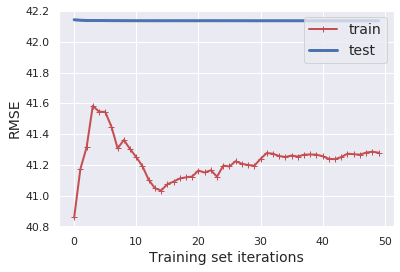

In [51]:
lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], 100000)

### Degree 4

In [77]:
del df
del df_train
del df_test
del df_train_transformed
del df_test_transformed

In [68]:
df, df_train, df_test, df_train_transformed, df_test_transformed = reset_data()

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 

Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Fit data
Fitting feature ORIGIN
Fitting feature UNIQUE_CARRIER
Fitting feature DEST
Encode categorical features...
Encoding feature ORIGIN ...
Encoding feature UNIQUE_CARRIER ...
Encoding feature DEST ...
Features selected (in order): Index(['ORIGIN', 'CRS_DEP_TIME', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
       'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'DISTANCE',
       'CRS_ELAPSED_TIME'],
      dtype='object')
Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Encode categorical features...
Encoding feature ORIGIN ...
Encoding feature UNIQUE_CARRIER ...
Encoding feature DEST ...
Features selected (in order): Index(['ORIGIN', 'CRS_DEP_TIME', 'MONTH', 'DAY_OF_MONTH

In [69]:
df_train_transformed

array([[ 4.35812975e-01, -1.02983686e+00,  1.49760716e+00, ...,
         2.68000000e+02,  1.00000000e+01,  1.96000000e+02],
       [-2.33459447e-01, -1.50981366e-01,  7.02313377e-01, ...,
         2.73000000e+02,  3.00000000e+00,  6.50000000e+01],
       [ 2.13396986e-02,  1.60672962e+00,  1.15676697e+00, ...,
         1.60000000e+02,  3.00000000e+00,  7.80000000e+01],
       ...,
       [-6.58124689e-01,  1.31377779e+00, -5.47433999e-01, ...,
         1.25000000e+02,  3.00000000e+00,  2.10000000e+02],
       [ 1.29533542e+00,  1.02082596e+00, -1.34272778e+00, ...,
         1.25000000e+02,  3.00000000e+00,  2.41000000e+02],
       [ 5.85295140e-01, -4.43933197e-01, -9.29804078e-02, ...,
         2.85000000e+02,  5.00000000e+00,  5.50000000e+01]])

In [70]:
poly = PolynomialFeaturesUnivariateAdder(n_degrees = 4)
df_train_transformed = poly.fit_transform(df_train_transformed)
df_test_transformed = poly.transform(df_test_transformed)

Adding polynomial features


Adding polynomial features


RMSE : 42.02846332497123


Calculating learning curve for 50 iterations


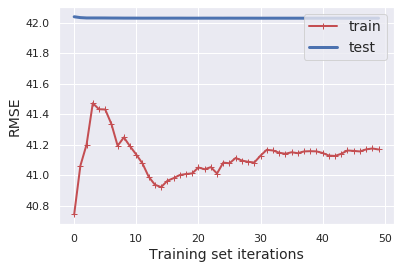

In [71]:
lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], 100000)

In [75]:
lin_reg.summary

Help on LinearRegression in module sklearn.linear_model.base object:

class LinearRegression(LinearModel, sklearn.base.RegressorMixin, sklearn.base.MultiOutputMixin)
 |  LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)
 |  
 |  Ordinary least squares Linear Regression.
 |  
 |  Parameters
 |  ----------
 |  fit_intercept : boolean, optional, default True
 |      whether to calculate the intercept for this model. If set
 |      to False, no intercept will be used in calculations
 |      (e.g. data is expected to be already centered).
 |  
 |  normalize : boolean, optional, default False
 |      This parameter is ignored when ``fit_intercept`` is set to False.
 |      If True, the regressors X will be normalized before regression by
 |      subtracting the mean and dividing by the l2-norm.
 |      If you wish to standardize, please use
 |      :class:`sklearn.preprocessing.StandardScaler` before calling ``fit`` on
 |      an estimator with ``normalize=False

# Annex : unused code

In [55]:
'''from sklearn import linear_model

regressor = linear_model.SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
regressor.fit(df_transformed, df_train[model1_label])
'''

'from sklearn import linear_model\n\nregressor = linear_model.SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)\nregressor.fit(df_transformed, df_train[model1_label])\n'

In [56]:
'''
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(df_train_transformed, df_train[model1_label])
'''

'\nfrom sklearn.svm import SVR\n\nsvm_reg = SVR(kernel="linear")\nsvm_reg.fit(df_train_transformed, df_train[model1_label])\n'

In [57]:
'''
df_test_predictions = svm_reg.predict(df_test_transformed)
svm_mse = mean_squared_error(df_test[model1_label], df_test_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse
'''

'\ndf_test_predictions = svm_reg.predict(df_test_transformed)\nsvm_mse = mean_squared_error(df_test[model1_label], df_test_predictions)\nsvm_rmse = np.sqrt(svm_mse)\nsvm_rmse\n'

In [58]:
'''
from sklearn.model_selection import StratifiedShuffleSplit

stratified_split_train = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
'''

'\nfrom sklearn.model_selection import StratifiedShuffleSplit\n\nstratified_split_train = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)\n'

poly = PolynomialFeatures(degree=3)
poly.fit(df_train_transformed)
df_train_transformed = poly.transform(df_train_transformed)
df_test_transformed = poly.transform(df_test_transformed)

df_train_transformed.shape

if (EXECUTE_INTERMEDIATE_MODELS == True):
    lin_reg = LinearRegression()
    lin_reg.fit(df_train_transformed, df_train[model1_label])

if (EXECUTE_INTERMEDIATE_MODELS == True):
    evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

evaluate_model_MAE(lin_reg, df_test_transformed, df_test[model1_label])

# This code is now in a transformer function :
n_degrees = 3
n_features = df_train_transformed.shape[1]

nb_instances = df_train_transformed.shape[0]
df_poly = np.empty((nb_instances, 0)) # Create empty array of nb_instances line and 0 features yet (we'll concatenate polynomial features to it)

progbar = tqdm(range(n_features))
print('Adding polynomial features')

for feature_index in range(n_features):    
    df_1feature = df_train_transformed[:,feature_index]  # Reshape 
    
    for n_degree in range(n_degrees):
        df_poly = np.c_[df_poly, np.power(df_1feature, n_degree + 1)]
    
    progbar.update(1)
    
# Add bias (intercept)
df_poly = np.c_[df_poly, np.ones((len(df_poly), 1))]  # add x0 = 1 feature